# Extracting movie ID embeddings with keras

Here is a walk-through using a solution described at [kaggle](https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras). It's actually older than the otherVersions that I have now that do it manually but I'm leaving in here in case it's useful to me in the future.

In [25]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    return df_ratings

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes + 1 # encode 1..n
    
df = load(n=50_000)
df.head(5)

,userId,movieId,rating
0,274,57528,3.5
1,76,2791,4.0
2,307,2160,3.0
3,552,5378,4.0
4,210,96610,3.5


In [26]:
import re

df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.iloc[1000:1005]

p = re.compile(r'[()0-9]+$')
df_movies['title'] = df_movies['title'].map(lambda x: p.sub('', x).strip())
df_movies.iloc[1000:1005]

df = df.merge(df_movies, on='movieId')
df.head(2)

,userId,movieId,rating,title,genres
0,274,57528,3.5,Rambo (Rambo 4),Action|Drama|Thriller|War
1,122,57528,4.0,Rambo (Rambo 4),Action|Drama|Thriller|War


In [27]:
df.groupby('genres').count().sort_values('userId', ascending=False).head(5)

,userId,movieId,rating,title
genres,,,,
Comedy,3538,3538,3538,3538
Drama,3083,3083,3083,3083
Comedy|Romance,1981,1981,1981,1981
Comedy|Drama|Romance,1489,1489,1489,1489
Drama|Romance,1447,1447,1447,1447


Let's filter for two different genres Sci-Fi and Romance to see if they separate in space.

In [28]:
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
print(len(df), 'movies that are Comedy or Drama')
df.head(2)

6621 movies that are Comedy or Drama


,userId,movieId,rating,title,genres
3,76,2791,4.0,Airplane!,Comedy
4,313,2791,3.0,Airplane!,Comedy


In [29]:
compress_cats(df, 'movieId')
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
3,67,386,4.0,Airplane!,Comedy
4,270,386,3.0,Airplane!,Comedy


In [30]:
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()
df_movies.head(3)

,movieId,title,genres
21319,1,Father of the Bride Part II,Comedy
40117,2,Nixon,Drama
43020,3,Four Rooms,Comedy


In [31]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback


In [32]:
# Copied verbatim from https://www.kaggle.com/colinmorris/embedding-layers
# under http://www.apache.org/licenses/LICENSE-2.0 license
hidden_units = (200,)
movie_embedding_size = 32
user_embedding_size = 32

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = tf.keras.Input(shape=(1,), name='user_id')
movie_id_input = tf.keras.Input(shape=(1,), name='movie_id')
user_embedded = tf.keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = tf.keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = tf.keras.layers.Concatenate()([user_embedded, movie_embedded])
out = tf.keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = tf.keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = tf.keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = tf.keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
#model.summary(line_length=88)

In [33]:
# Copied verbatim from https://www.kaggle.com/colinmorris/embedding-layers
# under http://www.apache.org/licenses/LICENSE-2.0 license
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.optimizers.Adam(0.005),
    loss='MSE',
    metrics=['mae'],
)
history = model.fit(
    [df.userId, df.movieId],
    df.rating,
    batch_size=50,
    epochs=20,
    verbose=0,
    validation_split=.05,
    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
)

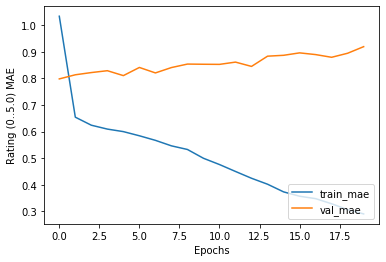

In [34]:
import matplotlib.pyplot as plt

plt.ylabel("Rating (0..5.0) MAE")
plt.xlabel("Epochs")
accur = history.history['mae']
plt.plot(accur, label='train_mae')
val_accur = history.history['val_mae']
plt.plot(val_accur, label='val_mae')
# plt.xlim(0, 200)
#plt.ylim(0.0, 1.00)
plt.legend(loc='lower right')
plt.show()

In [35]:
embedding_layer = model.get_layer('movie_embedding')
movie_embeddings = embedding_layer.get_weights()[0]
movie_embeddings.shape

(1483, 32)

## Use RF model to test embeddings

A random forest is easily able to capture the structure in the training data, but not in a general way. The out of bag and validation R^2 scores are terrible, barely better than just guessing the average.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def baseline(df):
    X = df[['movieId','userId']]
    y = df['rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_train, y_train)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_train, y_train):.3f}")
    print(f"Valid R^2 {rf.score(X_test, y_test):.3f}")
    
baseline(df)

OOB R^2 0.041
Train R^2 0.869
Valid R^2 0.061


In [37]:
X = df[['movieId','userId']]
y = df['rating']
X_emb = np.concatenate([movie_embeddings[X['movieId']],movie_embeddings[X['userId']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(f"OOB R^2 {rf.oob_score_:.3f}")
print(f"Train R^2 {rf.score(X_train, y_train):.3f}")
print(f"Valid R^2 {rf.score(X_test, y_test):.3f}")

OOB R^2 0.372
Train R^2 0.914
Valid R^2 0.335


Ah! So it looks like these embeddings are doing something because we get a much better validation score than using the raw categorical variables.

In [20]:
from sklearn.decomposition import PCA

def plot_embeddings(df, movie_embeddings, n):
    df_small = df[0:n].copy()
    plt.figure(figsize=(10,10))
    vecs = [movie_embeddings[m] for m in df_small['movieId']]
    genres = df_small['genres'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(vecs)
    for i,t in enumerate(df_small['title']):
#         print(i, genres[i], t)#, vecs2D[i])
        c = 'k' if 'Comedy' in genres[i] else 'r'
        plt.text(vecs2D[i,0], vecs2D[i,1], t, fontsize=6, c=c)
#     plt.xlim(-.5,.5)
#     plt.ylim(-.2,.2)
    plt.savefig("/tmp/embeddings.pdf")
    #plt.show()

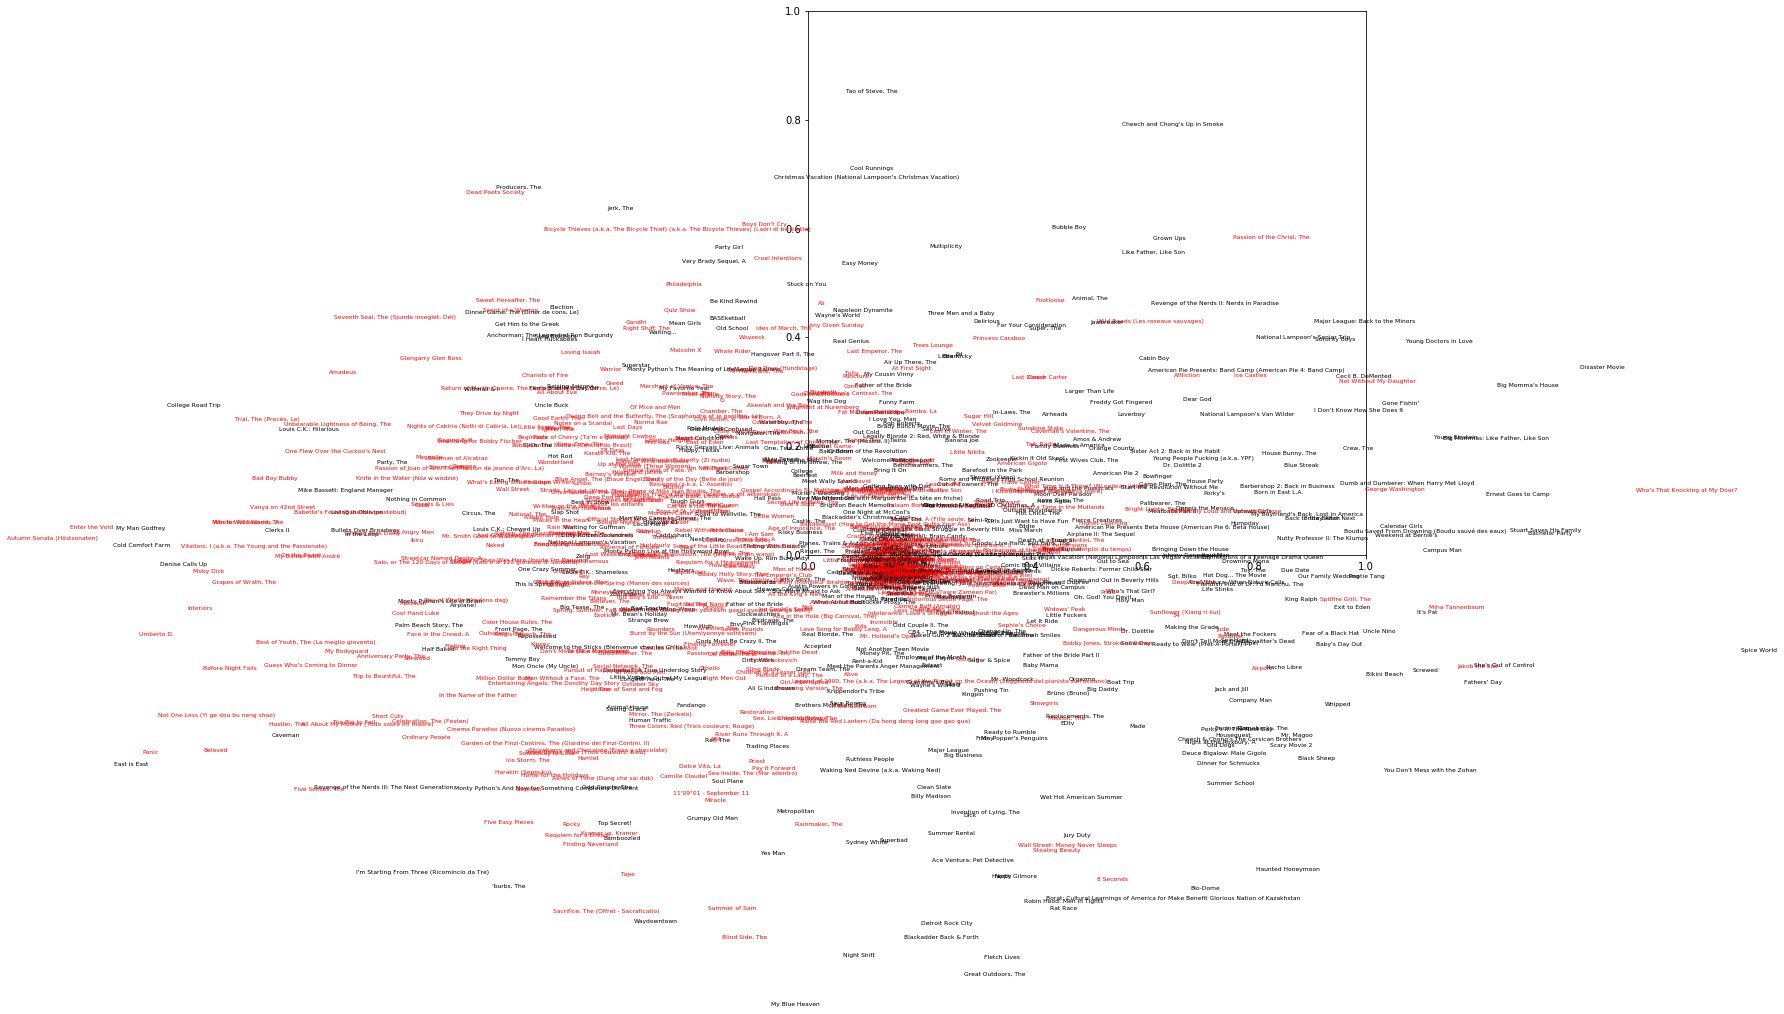

In [21]:
plot_embeddings(df_movies, movie_embeddings, 1000)

In [22]:
# PCA didn't work try TSNE

# Useful code derived from Shikhar Gupta's great discussion at
# https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(movie_embeddings)
plot_x = tsne_results[:,0]
plot_y = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1178 samples in 0.001s...
[t-SNE] Computed neighbors for 1178 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1178
[t-SNE] Computed conditional probabilities for sample 1178 / 1178
[t-SNE] Mean sigma: 0.127765
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.608757
[t-SNE] KL divergence after 1000 iterations: 1.457788


In [23]:
tsne_results.shape

(1178, 2)

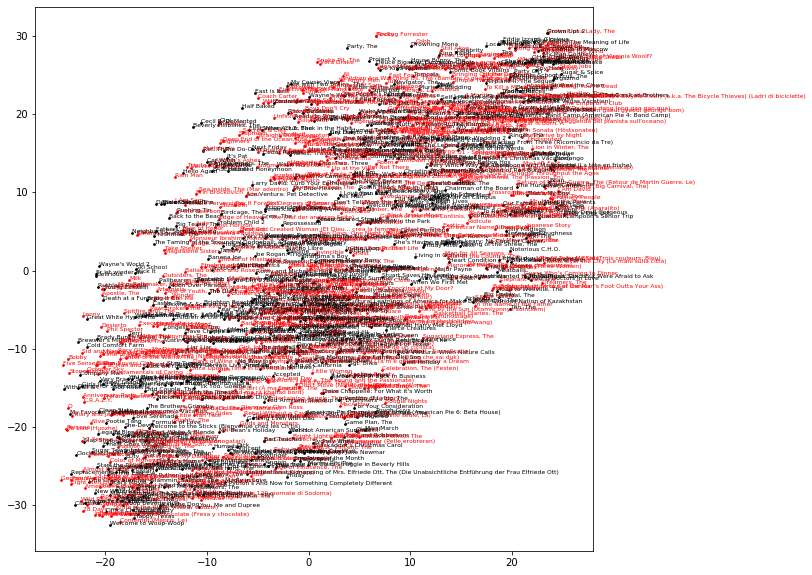

In [24]:
n = 2000
df_small = df_movies[0:n].copy()
plt.figure(figsize=(10,10))
genres = df_small['genres'].values
for i,t in enumerate(df_small['title']):
    #print(i,t,genres[i])
    c = 'k' if 'Comedy' in genres[i] else 'r'
    plt.text(plot_x[i], plot_y[i], t, fontsize=6, c=c)
    plt.scatter(plot_x[i], plot_y[i], s=3, c=c)
plt.show()

In [17]:
plot_x[i], plot_y[i]

(11.50996, 3.8449836)